In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline


In [2]:
import tensorflow as tf
from tensorflow import keras

In [3]:
from tensorflow.keras.preprocessing.image import load_img


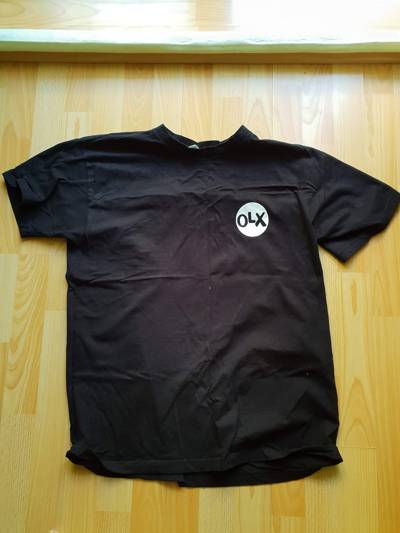

In [4]:
path = './clothing-dataset-small/train/t-shirt'
name = '5f0a3fa0-6a3d-4b68-b213-72766a643de7.jpg'
fullname = f'{path}/{name}'
load_img(fullname)


In [5]:
img=load_img(fullname,target_size=(299,299))

In [6]:
x=np.array(img)
x.shape

(299, 299, 3)

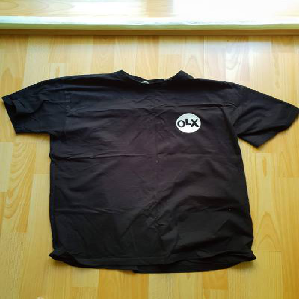

In [7]:
img

## pre trained CNN

In [8]:
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.xception import preprocess_input
from tensorflow.keras.applications.xception import decode_predictions


In [9]:
model = Xception(weights='imagenet', input_shape=(299, 299, 3))


In [10]:
X=np.array([x])

In [11]:
X.shape

(1, 299, 299, 3)

In [12]:
X=preprocess_input(X)

In [13]:
pred=model.predict(X)

1/1 [==============================] - 2s 2s/step


In [14]:
decode_predictions(pred)


[[('n03595614', 'jersey', 0.67924446),
  ('n02916936', 'bulletproof_vest', 0.039600294),
  ('n04370456', 'sweatshirt', 0.035299614),
  ('n03710637', 'maillot', 0.010884158),
  ('n04525038', 'velvet', 0.0018057639)]]

## Transfer learning
reading data with ImageDataGenerator

train Xception on smaller images

In [15]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [16]:
train_gen=ImageDataGenerator(preprocessing_function=preprocess_input)

In [17]:
train_ds=train_gen.flow_from_directory("./clothing-dataset-small/train",target_size=(150,150),batch_size=32)

Found 3068 images belonging to 10 classes.


In [18]:
train_ds.class_indices

{'dress': 0,
 'hat': 1,
 'longsleeve': 2,
 'outwear': 3,
 'pants': 4,
 'shirt': 5,
 'shoes': 6,
 'shorts': 7,
 'skirt': 8,
 't-shirt': 9}

In [19]:
X,y=next(train_ds)

In [20]:
X.shape

(32, 150, 150, 3)

In [21]:
val_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

val_ds = val_gen.flow_from_directory(
    './clothing-dataset-small/validation',
    target_size=(150, 150),
    batch_size=32,
    shuffle=False
)


Found 341 images belonging to 10 classes.


In [22]:
#no dense layer
base_model=Xception(weights='imagenet',include_top=False
                   ,input_shape=(150,150,3))
#freeze convulation 
base_model.trainable=False

In [23]:
#inputs = shirt
inputs=keras.Input(shape=(150,150,3))
#put input inside our model and produce 3D
base=base_model(inputs)
#converting 3D/2D to 1D using pooling
vectors = keras.layers.GlobalAveragePooling2D()(base)
#add dense layers to turn vectors into prediction with 10 layers (10 diff classes)
outputs=keras.layers.Dense(10)(vectors)

model=keras.Model(inputs,outputs)

In [24]:
preds=model.predict(X)

1/1 [==============================] - 2s 2s/step


In [25]:
preds.shape

(32, 10)

In [26]:
#optimizer to find best weight (change weight)
learning_rate=0.01
optimizer=keras.optimizers.Adam(learning_rate=learning_rate)
#loss categorical cross entropy because multiclass classification
loss=keras.losses.CategoricalCrossentropy(from_logits=True)

In [27]:
model.compile(optimizer=optimizer,loss=loss,metrics=['accuracy'])

In [28]:
history=model.fit(train_ds,epochs=10,validation_data=val_ds)

Epoch 1/10


96/96 [==============================] - 56s 552ms/step - loss: 1.2739 - accuracy: 0.6682 - val_loss: 0.8935 - val_accuracy: 0.7419
Epoch 2/10
96/96 [==============================] - 52s 536ms/step - loss: 0.6035 - accuracy: 0.8181 - val_loss: 0.8419 - val_accuracy: 0.8035
Epoch 3/10
96/96 [==============================] - 54s 561ms/step - loss: 0.3004 - accuracy: 0.8993 - val_loss: 0.9459 - val_accuracy: 0.7683
Epoch 4/10
96/96 [==============================] - 54s 563ms/step - loss: 0.3169 - accuracy: 0.8950 - val_loss: 0.8677 - val_accuracy: 0.7889
Epoch 5/10
96/96 [==============================] - 52s 538ms/step - loss: 0.2083 - accuracy: 0.9286 - val_loss: 0.8644 - val_accuracy: 0.8094
Epoch 6/10
96/96 [==============================] - 52s 539ms/step - loss: 0.1082 - accuracy: 0.9635 - val_loss: 0.8711 - val_accuracy: 0.8123
Epoch 7/10
96/96 [==============================] - 52s 536ms/step - loss: 0.0912 - accuracy: 0.9681 - val_loss: 0.8569 - val_accuracy: 0.82

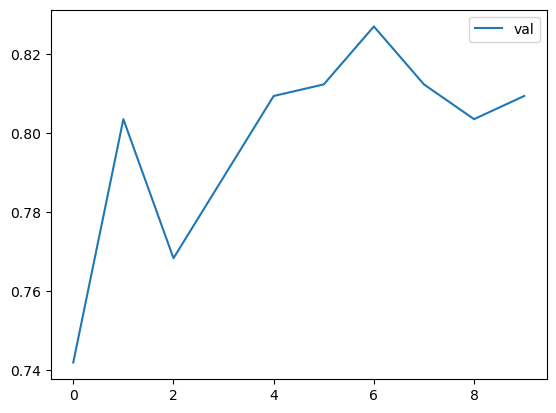

In [29]:
#plt.plot(history.history['accuracy'],label='train')
plt.plot(history.history['val_accuracy'],label='val')

plt.legend()

## Learning Rate

In [30]:
def make_model(learning_rate=0.01):
    base_model = Xception(
        weights='imagenet',
        include_top=False,
        input_shape=(150, 150, 3)
    )

    base_model.trainable = False

    #########################################

    inputs = keras.Input(shape=(150, 150, 3))
    base = base_model(inputs, training=False)
    vectors = keras.layers.GlobalAveragePooling2D()(base)
    outputs = keras.layers.Dense(10)(vectors)
    model = keras.Model(inputs, outputs)
    
    #########################################

    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    loss = keras.losses.CategoricalCrossentropy(from_logits=True)

    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=['accuracy']
    )
    
    return model


In [31]:
scores = {}

for lr in [0.0001, 0.001, 0.01, 0.1]:
    print(lr)

    model = make_model(learning_rate=lr)
    history = model.fit(train_ds, epochs=10, validation_data=val_ds)
    scores[lr] = history.history

    print()
    print()


0.0001
Epoch 1/10
96/96 [==============================] - 61s 604ms/step - loss: 1.9885 - accuracy: 0.3413 - val_loss: 1.6438 - val_accuracy: 0.4633
Epoch 2/10
96/96 [==============================] - 54s 560ms/step - loss: 1.4459 - accuracy: 0.5365 - val_loss: 1.2915 - val_accuracy: 0.5630
Epoch 3/10
96/96 [==============================] - 54s 564ms/step - loss: 1.1901 - accuracy: 0.6213 - val_loss: 1.0987 - val_accuracy: 0.6452
Epoch 4/10
96/96 [==============================] - 58s 606ms/step - loss: 1.0392 - accuracy: 0.6711 - val_loss: 0.9746 - val_accuracy: 0.6716
Epoch 5/10
96/96 [==============================] - 52s 540ms/step - loss: 0.9385 - accuracy: 0.7040 - val_loss: 0.8915 - val_accuracy: 0.7214
Epoch 6/10
96/96 [==============================] - 58s 604ms/step - loss: 0.8659 - accuracy: 0.7239 - val_loss: 0.8327 - val_accuracy: 0.7478
Epoch 7/10
96/96 [==============================] - 65s 669ms/step - loss: 0.8087 - accuracy: 0.7409 - val_loss: 0.7895 - val_accuracy:

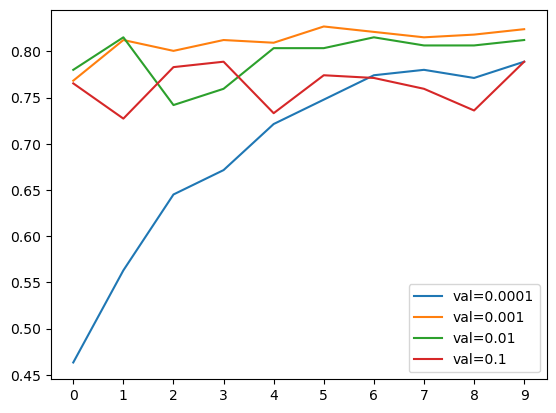

In [32]:
for lr, hist in scores.items():
    #plt.plot(hist['accuracy'], label=('train=%s' % lr))
    plt.plot(hist['val_accuracy'], label=('val=%s' % lr))

plt.xticks(np.arange(10))
plt.legend()


In [33]:
del scores[0.1]
del scores[0.0001]


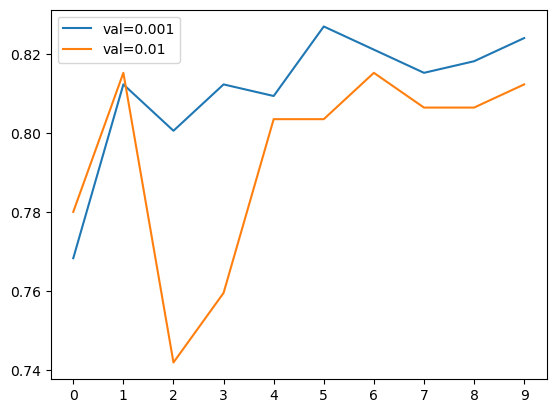

In [34]:
for lr, hist in scores.items():
    #plt.plot(hist['accuracy'], label=('train=%s' % lr))
    plt.plot(hist['val_accuracy'], label=('val=%s' % lr))

plt.xticks(np.arange(10))
plt.legend()


In [35]:
learning_rate = 0.001


# Checkpoint

In [36]:
model.save_weights('model_v1.h5', save_format='h5')

In [37]:
checkpoint=keras.callbacks.ModelCheckpoint(
    'xception_v1{epoch:02d}_{val_accuracy:.3f}.h5',
    save_best_only=True,
    monitor='val_accuracy',
    mode='max'
)

In [38]:
learning_rate = 0.001

model = make_model(learning_rate=learning_rate)

history = model.fit(
    train_ds,
    epochs=10,
    validation_data=val_ds,
    callbacks=[checkpoint]
)


Epoch 1/10
96/96 [==============================] - ETA: 0s - loss: 1.0582 - accuracy: 0.6431

C:\Users\sondu\AppData\Roaming\Python\Python310\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


96/96 [==============================] - 62s 615ms/step - loss: 1.0582 - accuracy: 0.6431 - val_loss: 0.7159 - val_accuracy: 0.7742
Epoch 2/10
96/96 [==============================] - 59s 610ms/step - loss: 0.6242 - accuracy: 0.7872 - val_loss: 0.6302 - val_accuracy: 0.8035
Epoch 3/10
96/96 [==============================] - 59s 618ms/step - loss: 0.5044 - accuracy: 0.8259 - val_loss: 0.5824 - val_accuracy: 0.8182
Epoch 4/10
96/96 [==============================] - 62s 646ms/step - loss: 0.4221 - accuracy: 0.8628 - val_loss: 0.5701 - val_accuracy: 0.8152
Epoch 5/10
96/96 [==============================] - 56s 577ms/step - loss: 0.3714 - accuracy: 0.8778 - val_loss: 0.5483 - val_accuracy: 0.8211
Epoch 6/10
96/96 [==============================] - 58s 605ms/step - loss: 0.3284 - accuracy: 0.9038 - val_loss: 0.5322 - val_accuracy: 0.8387
Epoch 7/10
96/96 [==============================] - 56s 585ms/step - loss: 0.2877 - accuracy: 0.9185 - val_loss: 0.5296 - val_accuracy: 0.8211
Epoch 8/10

In [39]:
def make_model(learning_rate=0.01, size_inner=100):
    base_model = Xception(
        weights='imagenet',
        include_top=False,
        input_shape=(150, 150, 3)
    )

    base_model.trainable = False

    #########################################

    inputs = keras.Input(shape=(150, 150, 3))
    base = base_model(inputs, training=False)
    vectors = keras.layers.GlobalAveragePooling2D()(base)
    
    inner = keras.layers.Dense(size_inner, activation='relu')(vectors)
    #use logits directly
    outputs = keras.layers.Dense(10)(inner)
    
    model = keras.Model(inputs, outputs)
    
    #########################################

    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    loss = keras.losses.CategoricalCrossentropy(from_logits=True)

    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=['accuracy']
    )
    
    return model


In [40]:
learning_rate = 0.001

scores = {}

for size in [10, 100, 1000]:
    print(size)

    model = make_model(learning_rate=learning_rate, size_inner=size)
    history = model.fit(train_ds, epochs=10, validation_data=val_ds)
    scores[size] = history.history

    print()
    print()


10
Epoch 1/10
96/96 [==============================] - 53s 519ms/step - loss: 1.6265 - accuracy: 0.4743 - val_loss: 1.2645 - val_accuracy: 0.6070
Epoch 2/10
96/96 [==============================] - 50s 515ms/step - loss: 1.1098 - accuracy: 0.6333 - val_loss: 1.0531 - val_accuracy: 0.6452
Epoch 3/10
96/96 [==============================] - 49s 512ms/step - loss: 0.9145 - accuracy: 0.6881 - val_loss: 0.9313 - val_accuracy: 0.6921
Epoch 4/10
96/96 [==============================] - 50s 517ms/step - loss: 0.7604 - accuracy: 0.7513 - val_loss: 0.8066 - val_accuracy: 0.7331
Epoch 5/10
96/96 [==============================] - 53s 557ms/step - loss: 0.6414 - accuracy: 0.8015 - val_loss: 0.7706 - val_accuracy: 0.7390
Epoch 6/10
96/96 [==============================] - 52s 546ms/step - loss: 0.5654 - accuracy: 0.8233 - val_loss: 0.7000 - val_accuracy: 0.7713
Epoch 7/10
96/96 [==============================] - 53s 555ms/step - loss: 0.5004 - accuracy: 0.8367 - val_loss: 0.6965 - val_accuracy: 0.7

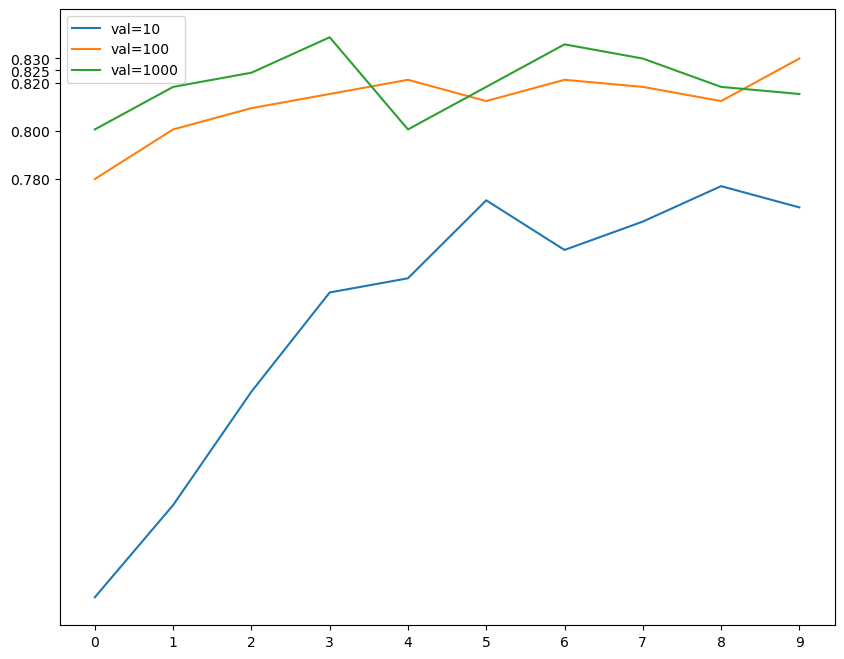

In [79]:
plt.figure(figsize=(10, 8))
for size, hist in scores.items():
    plt.plot(hist['val_accuracy'], label=('val=%s' % size))

plt.xticks(np.arange(10))
plt.yticks([0.78, 0.80, 0.82, 0.825, 0.83])
plt.legend()


In [42]:
train_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
#     vertical_flip=True,
)

train_ds = train_gen.flow_from_directory(
    './clothing-dataset-small/train',
    target_size=(150, 150),
    batch_size=32
)

val_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

val_ds = val_gen.flow_from_directory(
    './clothing-dataset-small/validation',
    target_size=(150, 150),
    batch_size=32,
    shuffle=False
)


Found 3068 images belonging to 10 classes.
Found 341 images belonging to 10 classes.


## Training a larger model
train a 299x299 model

In [43]:
def make_model(input_size=150, learning_rate=0.01, size_inner=100,
               droprate=0.5):

    base_model = Xception(
        weights='imagenet',
        include_top=False,
        input_shape=(input_size, input_size, 3)
    )

    base_model.trainable = False

    #########################################

    inputs = keras.Input(shape=(input_size, input_size, 3))
    base = base_model(inputs, training=False)
    vectors = keras.layers.GlobalAveragePooling2D()(base)
    
    inner = keras.layers.Dense(size_inner, activation='relu')(vectors)
    drop = keras.layers.Dropout(droprate)(inner)
    
    outputs = keras.layers.Dense(10)(drop)
    
    model = keras.Model(inputs, outputs)
    
    #########################################

    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    loss = keras.losses.CategoricalCrossentropy(from_logits=True)

    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=['accuracy']
    )
    
    return model


In [44]:
input_size = 299


In [45]:
train_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    shear_range=10,
    zoom_range=0.1,
    horizontal_flip=True
)

train_ds = train_gen.flow_from_directory(
    './clothing-dataset-small/train',
    target_size=(input_size, input_size),
    batch_size=32
)


val_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

val_ds = train_gen.flow_from_directory(
    './clothing-dataset-small/validation',
    target_size=(input_size, input_size),
    batch_size=32,
    shuffle=False
)


Found 3068 images belonging to 10 classes.
Found 341 images belonging to 10 classes.


In [46]:
checkpoint = keras.callbacks.ModelCheckpoint(
    'xception_v4_1_{epoch:02d}_{val_accuracy:.3f}.h5',
    save_best_only=True,
    monitor='val_accuracy',
    mode='max'
)


In [60]:
learning_rate = 0.0005
size = 100
droprate = 0.2

model = make_model(
    input_size=input_size,
    learning_rate=learning_rate,
    size_inner=size,
    droprate=droprate
)

history = model.fit(train_ds, epochs=10, validation_data=val_ds,
                   callbacks=[checkpoint])


Epoch 1/10
96/96 [==============================] - 222s 2s/step - loss: 0.9948 - accuracy: 0.6825 - val_loss: 0.5477 - val_accuracy: 0.8446
Epoch 2/10
96/96 [==============================] - 231s 2s/step - loss: 0.5270 - accuracy: 0.8246 - val_loss: 0.4658 - val_accuracy: 0.8299
Epoch 3/10
96/96 [==============================] - 218s 2s/step - loss: 0.4374 - accuracy: 0.8559 - val_loss: 0.4217 - val_accuracy: 0.8592
Epoch 4/10
96/96 [==============================] - 221s 2s/step - loss: 0.3859 - accuracy: 0.8683 - val_loss: 0.4108 - val_accuracy: 0.8592
Epoch 5/10
96/96 [==============================] - 224s 2s/step - loss: 0.3442 - accuracy: 0.8833 - val_loss: 0.3863 - val_accuracy: 0.8592
Epoch 6/10
96/96 [==============================] - 218s 2s/step - loss: 0.3269 - accuracy: 0.8856 - val_loss: 0.3941 - val_accuracy: 0.8680
Epoch 7/10
96/96 [==============================] - 233s 2s/step - loss: 0.2929 - accuracy: 0.9038 - val_loss: 0.3676 - val_accuracy: 0.8680
Epoch 8/10
96

## Using the model

In [48]:
test_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

test_ds = test_gen.flow_from_directory(
    './clothing-dataset-small/test',
    target_size=(299, 299),
    batch_size=32,
    shuffle=False
)


Found 372 images belonging to 10 classes.


In [62]:
model = keras.models.load_model('xception_v4_1_10_0.889.h5')


In [63]:
model.evaluate(test_ds)


12/12 [==============================] - 24s 2s/step - loss: 0.3054 - accuracy: 0.8871


[0.3053508996963501, 0.8870967626571655]

In [64]:
path = 'clothing-dataset-small/test/pants/c8d21106-bbdb-4e8d-83e4-bf3d14e54c16.jpg'


In [65]:
img = load_img(path, target_size=(299, 299))


In [66]:
x = np.array(img)
X = np.array([x])
X.shape


(1, 299, 299, 3)

In [67]:
X = preprocess_input(X)


In [68]:
pred=model.predict(X)

1/1 [==============================] - 1s 841ms/step


In [69]:
classes = [
    'dress',
    'hat',
    'longsleeve',
    'outwear',
    'pants',
    'shirt',
    'shoes',
    'shorts',
    'skirt',
    't-shirt'
]


In [70]:
dict(zip(classes, pred[0]))


{'dress': -2.1344373,
 'hat': -5.5963993,
 'longsleeve': -1.6437684,
 'outwear': -2.7730215,
 'pants': 9.646762,
 'shirt': -2.0319457,
 'shoes': -4.7426467,
 'shorts': 4.318224,
 'skirt': -3.7230816,
 't-shirt': -2.0256665}

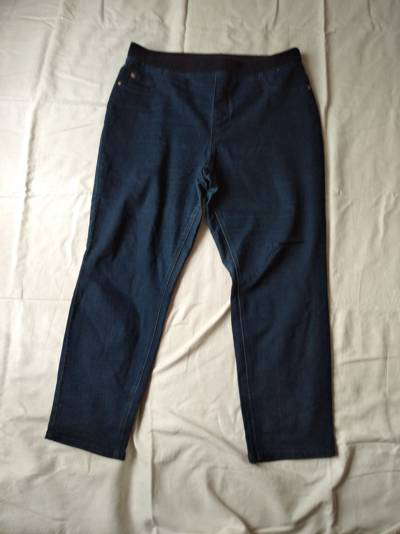

In [71]:
load_img(path)